In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

In [2]:
torch.manual_seed(42)

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch_dtype
)
pipe = pipe.to(device)
pipe.enable_attention_slicing() 
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [4]:
pipe.scheduler.set_timesteps(40)

In [5]:
prompt = "jumbo shrimp next to a tiny house"
text_input = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

In [6]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]

In [7]:
text_embeddings.requires_grad_(True)
text_embeddings.retain_grad()

In [8]:
text_embeddings.requires_grad

True

In [9]:
batch_size = 1
max_length = text_input.input_ids.shape[-1]
uncond_input = pipe.tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

concat_text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
concat_text_embeddings = concat_text_embeddings.to(torch.float16)

In [10]:
text_embeddings.shape

torch.Size([1, 77, 768])

In [11]:
concat_text_embeddings.shape

torch.Size([2, 77, 768])

In [12]:
# with torch.no_grad():
with torch.enable_grad():
    latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size
    latents = latents.to(torch_dtype) * pipe.scheduler.init_noise_sigma  # match scheduler expectations

/tmp/ipykernel_110923/36194376.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, pipe.unet.in_channels, 64, 64), device=device)  # typical latent size


In [13]:
x = latents

In [14]:
x.shape

torch.Size([1, 4, 64, 64])

In [15]:
import torch.utils.checkpoint as cp

def unet_forward(model_input, t, text_embeds):
    return pipe.unet(model_input, t, encoder_hidden_states=text_embeds).sample

guidance_scale = 7.5

for i, t in enumerate(pipe.scheduler.timesteps):
    model_input = pipe.scheduler.scale_model_input(x, t)
    model_input = torch.cat([x] * 2)
    print(i, end = " ")
    # dummy = torch.tensor(0.0, requires_grad=True, device=model_input.device)
    # Apply checkpointing
    noise_pred = cp.checkpoint(unet_forward, model_input, t, concat_text_embeddings)

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    scheduler_output = pipe.scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample

/home/shaunak/.virtualenvs/ML/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [16]:
pipe.vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [17]:
with torch.enable_grad():
    image = pipe.vae.decode(x / 0.18215)
    image = image.sample   

In [18]:
# write masking logic here
image.shape

torch.Size([1, 3, 512, 512])

In [19]:
# masking logic
N, C, H, W = image.shape
center = (120, 300)
radius = 100
Y, X = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
dist = (X - center[1])**2 + (Y - center[0])**2
mask_2d = (dist <= radius**2).float()
mask = mask_2d.unsqueeze(0).unsqueeze(0).expand(N, C, H, W).to(device)

In [20]:
# mask_np = mask[0, 0].detach().cpu().numpy()
# masked_area = np.zeros((*mask_np.shape, 4))
# masked_area[mask_np == 1] = [0.6, 1.0, 0.6, 0.4]
# masked_area[mask_np == 0] = [0.0, 0.0, 0.0, 0.5]
# plt.imshow(img_np, cmap='gray')
# plt.imshow(masked_area)
# plt.axis('off')
# plt.show()

In [21]:
image.shape

torch.Size([1, 3, 512, 512])

In [22]:
# MEAN is problematic, since the gradients are too small and with fp16 they are rounded down to 0
image_mean = (image * mask).sum()
image_mean.backward()

In [23]:
text_embeddings.grad

tensor([[[-4.7720e+03, -6.6680e+03, -6.6360e+03,  ...,  2.0700e+03,
          -7.5440e+03,  8.9600e+02],
         [-2.4100e+02, -1.8762e+02, -9.8938e+01,  ...,  2.2350e+02,
          -6.1250e+01,  1.0312e+02],
         [ 6.4900e+02,  2.8025e+02,  3.9775e+02,  ..., -4.3875e+02,
           8.1300e+02,  6.4250e+02],
         ...,
         [-6.3047e+00,  1.6699e+00, -2.1719e+00,  ...,  1.5518e+00,
           1.0049e+00,  2.9883e-01],
         [-6.2656e+00,  1.6826e+00, -2.1387e+00,  ...,  1.7666e+00,
           1.1572e+00,  2.1240e-01],
         [-6.4141e+00,  1.6934e+00, -2.3438e+00,  ...,  1.3008e+00,
           8.6865e-01,  6.4062e-01]]], device='cuda:0', dtype=torch.float16)

In [24]:
specials = {
    "bos_token": pipe.tokenizer.bos_token,
    "eos_token": pipe.tokenizer.eos_token,
    "pad_token": pipe.tokenizer.pad_token,
    "unk_token": pipe.tokenizer.unk_token,
    "additional_special_tokens": pipe.tokenizer.additional_special_tokens,
}

special_token_ids = set()

# Add basic special tokens
for attr in ["bos_token", "eos_token", "pad_token", "unk_token"]:
    token = getattr(pipe.tokenizer, attr, None)
    if token is not None:
        token_id = pipe.tokenizer.convert_tokens_to_ids(token)
        special_token_ids.add(token_id)

# Add additional special tokens (if any)
for token in pipe.tokenizer.additional_special_tokens:
    token_id = pipe.tokenizer.convert_tokens_to_ids(token)
    special_token_ids.add(token_id)

special_ids_tensor = torch.tensor(list(special_token_ids), device="cpu")
token_mask = ~torch.isin(text_input.input_ids[0], special_ids_tensor)
importance = (text_embeddings.grad[0, token_mask] * text_embeddings[0, token_mask]).norm(dim=-1)
final_importance = importance
if importance.norm() > 0:
    final_importance /= importance.norm()
if final_importance.sum() > 0:
    final_importance /= final_importance.sum()
token_ids = text_input.input_ids[0, token_mask]
for i, token_id in enumerate(token_ids):
    imp = final_importance[i]
    word = pipe.tokenizer.decode(token_id)
    print(f"Token: {word}, importance: {imp}")

Token: jumbo, importance: 0.055755615234375
Token: shrimp, importance: 0.341064453125
Token: next, importance: 0.05035400390625
Token: to, importance: 0.04376220703125
Token: a, importance: 0.0404052734375
Token: tiny, importance: 0.0487060546875
Token: house, importance: 0.419921875


In [25]:
image.shape

torch.Size([1, 3, 512, 512])

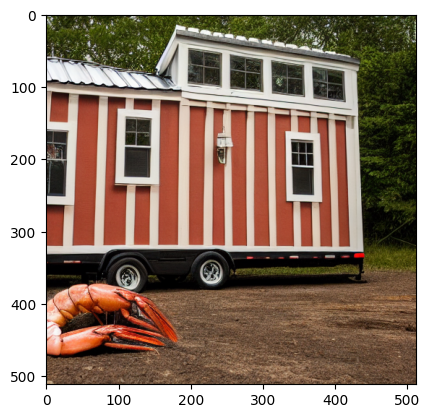

In [26]:
import numpy as np
img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy().astype(np.float32) # Squeeze if you want to remove the channel dimension
img_np = (img_np / 2 + 0.5)
img_np = np.clip(img_np, 0, 1)
import matplotlib.pyplot as plt
# Plot using matplotlib
plt.imshow(img_np, cmap='gray')

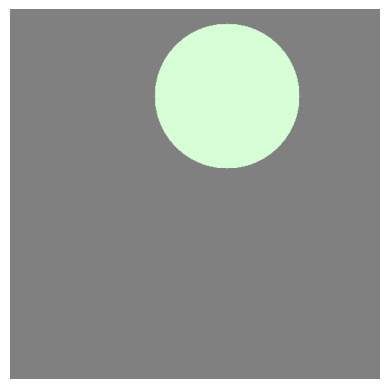

In [27]:
mask_np = mask[0, 0].detach().cpu().numpy()
masked_area = np.zeros((*mask_np.shape, 4))
masked_area[mask_np == 1] = [0.6, 1.0, 0.6, 0.4]
masked_area[mask_np == 0] = [0.0, 0.0, 0.0, 0.5]
# plt.imshow(img_np, cmap='gray')
plt.imshow(masked_area)
plt.axis('off')
plt.show()

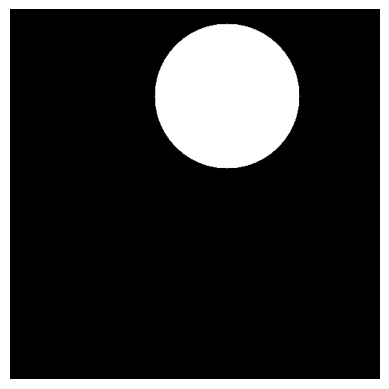

In [28]:
import numpy as np
mask_np = mask_2d.numpy()
plt.imshow(mask_np, cmap = 'gray')
plt.axis('off')
plt.savefig('masked_image.png', bbox_inches = 'tight', pad_inches = 0)

In [29]:
from PIL import Image

In [30]:
mask_rgb = np.stack([mask_np * 255]*3, axis=-1) 

In [31]:
Image.fromarray(mask_rgb.astype(np.uint8)).save("masked_image.png")

In [32]:
(mask_rgb == 256).sum()

np.int64(0)